**PLAN:**
- wstęp
- rozwój nowotworów bez podejmowania leczenia;
- rozwój nowotworów przy podjęciu leczenia;
- sprawdzenie, jak moment podjęcia leczenia wpływa na rozwój nowotworu
- opis metod numerycznych rozwiązywania PDE zaimplementowanych w py-pde.

Założenie: śmierć następuje w momencie, gdy liczba komórek z gęstością większą niż 0.5 przekracza 30%.
1. Symulacja bez leczenia - czas przeżycia
2. Symulacja z leczeniem - czas przeżycia, minimalny czas podjęcia leczenia
3. Opis rozwiązania równania

# Cancer modeling with partial differential equations

## Proliferation–invasion model. Cancer without any treatment.

$$\frac{\partial c}{\partial t} = D\nabla^2 c + \rho c\left(1-\frac{c}{K}\right)$$

This is a classical conservation–diffusion equation (Murray, 2003), in which $c(x, t)$ defines the concentration of malignant cells at location $x$ and time $t$, $D~(mm^2\,day^{−1})$ is the random motility (dispersal) coefficient defining the net rate of migration of the tumour cells, $\rho$ (per day) represents the net proliferation rate of the tumour cells (including mitosis and cell loss), $K$ is the limiting concentration of cells that a volume of tissue can hold (i.e., the carrying capacity of the tissue) and $\nabla^2$ represents the dispersal operator, the Laplacian, expressed mathematically as the sum of three second derivatives in space.

In [1]:
import os
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, PlotTracker, FieldCollection, UnitGrid
from scipy import optimize
from IPython.display import Image

In [21]:
class NoTreatmentModel(PDEBase):
    
    def __init__(self, D, rho, K, bc="natural"):
        self.D = D
        self.rho = rho
        self.bc = bc
        
    def evolution_rate(self, state, t=0):
        c = state
        dc_dt = self.D * c.laplace(self.bc) + self.rho*c  #*(1-c/self.K)
        return dc_dt
    
def compute_radius(idx_array):
    radius = (max(idx_array) - min(idx_array)) / 2
    return radius

def create_dir_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [22]:
D = 0.9
RHO = 1.16
K = 1
c_1 = 80  # smallest level of detection
N = 8000
T_MAX = 30

In [23]:
eq = NoTreatmentModel(D=D, rho=RHO, K=K)

**Assumptions:**

- We consider a tissue, which is a cube of size: $20\,cm \times 20\,cm \times 20\,cm$;
- For simulations we use a 3 dimensional Cartesian grid - each dimension having a size of 200. That means, every cell has a size of $1\,mm \times 1\,mm \times 1\,mm$ and a volume of $1\,mm^3$.
- The death occurs when tumor reaches radius ($r$) of $30\,mm$.

In [6]:
bound = 200
grid = UnitGrid([bound, bound, bound])
c = ScalarField(grid, 0)
c.data[bound//2-2:bound//2+2, bound//2-2:bound//2+2, bound//2-2:bound//2+2] = N

In [7]:
storage = MemoryStorage()

In [8]:
sol = eq.solve(c, t_range=T_MAX, dt=1e-1, tracker=["progress", storage.tracker(1)])

In [32]:
for dir_ in ['figs',
             os.path.join('figs', 'pngs'),
             os.path.join('figs', 'pngs', 'no_treatment'),
             os.path.join('figs', 'pngs', 'radiation'),
             os.path.join('figs', 'gifs')]:
    create_dir_if_not_exists(dir_)
    
radius_dict = {}
for i in range(0, T_MAX+1):
    if i == 0:
        ars = np.asarray((storage.data[i] >= c_1)).nonzero()
    else:
        ars = np.asarray((storage.data[i] <= 10*c_1) & (storage.data[i] >= c_1)).nonzero()
    current_radius = compute_radius(ars[0])
    radius_dict[i+1] = current_radius
    fig = px.scatter_3d(x=ars[0], y=ars[1], z=ars[2], range_x=[0, bound], range_y=[0, bound], range_z=[0, bound],
                       title=f'Tumor at time: {i+1} [months], radius: {current_radius} [mm]')
    fig.write_image(os.path.join('figs', 'pngs', 'no_treatment', f'tumor_{i}.png'))

KeyboardInterrupt: 

In [16]:
df = pd.Series(radius_dict).reset_index()
df.columns = ['time', 'radius']

In [17]:
t = np.arange(1, T_MAX+1, 1)
theoretical = 2*t*np.sqrt(RHO*D)*np.sqrt(1-(1/(RHO*t))*np.log((c_1/N)*(4*np.pi*D*t)**1.5))
theoretical_1 = 2*t*np.sqrt(RHO*D)

In [18]:
def f(t, D, RHO, c_1, N):
    return 2*t*np.sqrt(D*RHO)*np.sqrt(1-(1/(RHO*t))*np.log((c_1/N)*(4*np.pi*D*t)**1.5)) - 30

sol = optimize.root_scalar(f, args=(D, RHO, c_1, N), bracket=[14, 18], method='brentq')
time_of_death = sol.root
print(f'Time of death [months]: {time_of_death}')

Time of death [months]: 16.12635954486013


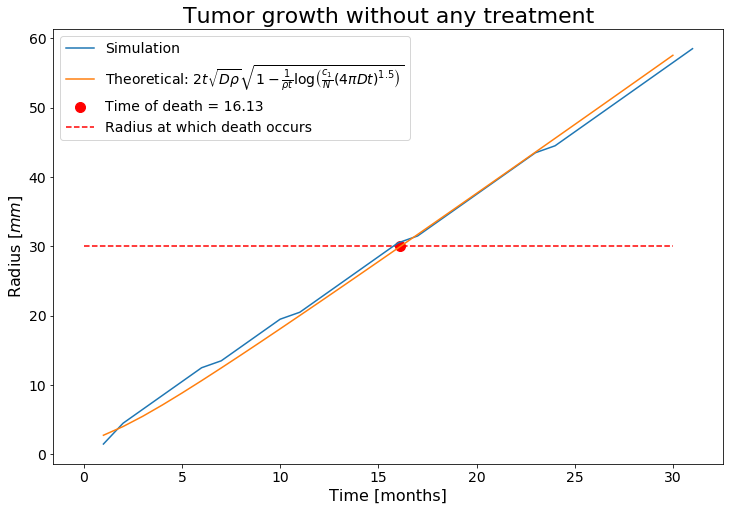

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df['time'].to_list(), df['radius'].to_list(), label='Simulation')
plt.plot(t, theoretical, label=r'Theoretical: $2t\sqrt{D\rho}\sqrt{1-\frac{1}{\rho t}\log\left(\frac{c_1}{N} (4\pi Dt)^{1.5}\right)}$')
plt.scatter(time_of_death, 30, s=100, c='red', label=f'Time of death = {round(time_of_death, 2)}')
plt.hlines(30, 0, 30, colors='red', linestyles='--', label='Radius at which death occurs')
plt.legend(fontsize=14)
plt.title('Tumor growth without any treatment', fontdict={'size': 22})
plt.xlabel('Time [months]', fontdict={'size': 16})
plt.ylabel(r'Radius [$mm$]', fontdict={'size': 16})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(os.path.join('figs', 'pngs', 'no_treatment_growth.png'))
plt.show()

**Warning:** This line might work only on Linux OS (gif creation)

In [15]:
!convert -delay 25 -loop 0 `ls -v figs/pngs/no_treatment/*.png` figs/gifs/no-treatment.gif

But the gif image is saved in the repository, so running this line should be possible

In [14]:
Image(url=os.path.join('figs', 'gifs', 'no-treatment.gif'))  

## Radiation Therapy Model

In [24]:
class RadiationTherapyModel(PDEBase):
    
    def __init__(self, D, rho, therapy_time, alpha, beta, dose, bc="natural"):
        self.D = D
        self.rho = rho
        self.bc = bc
        self.therapy_start = therapy_time[0]
        self.therapy_end = therapy_time[1]
        self.alpha = alpha
        self.beta = beta
        self.dose = dose
        
    def evolution_rate(self, state, t=0):
        c = state
        if t>=self.therapy_start and t<=self.therapy_end:
            R = 1 - np.exp(-(self.alpha*self.dose + self.beta*self.dose**2))
        else:
            R = 0
        print(R)
        dc_dt = self.D * c.laplace(self.bc) + self.rho*c - R*c  #*(1-c/self.K)
        return dc_dt
    

In [87]:
D = 0.9
RHO = 1.16
K = 1
c_1 = 80  # smallest level of detection
N = 8000
T_MAX = 30
THERAPY_TIME = [3, 100]
ALPHA = 0.7
BETA = 0.1
DOSE = 10

In [88]:
eq = RadiationTherapyModel(D, RHO, THERAPY_TIME, ALPHA, BETA, DOSE)
bound = 200
grid = UnitGrid([bound, bound, bound])
c = ScalarField(grid, 0)
c.data[bound//2-2:bound//2+2, bound//2-2:bound//2+2, bound//2-2:bound//2+2] = N

In [89]:
storage = MemoryStorage()
sol = eq.solve(c, t_range=T_MAX, dt=1e-1, tracker=["progress", storage.tracker(1)])

In [95]:
radius_dict = {}
for i in range(0, T_MAX+1):
    if i == 0:
        ars = np.asarray((storage.data[i] >= c_1)).nonzero()
    else:
        ars = np.asarray((storage.data[i] <= 10*c_1) & (storage.data[i] >= c_1)).nonzero()
    current_radius = compute_radius(ars[0])
    radius_dict[i+1] = current_radius
    if i>=THERAPY_TIME[0]:
        treatment = 'yes'
    else:
        treatment = 'no'
    fig = px.scatter_3d(x=ars[0], y=ars[1], z=ars[2], range_x=[0, bound], range_y=[0, bound], range_z=[0, bound],
                       title=f'Tumor at time: {i+1} [months], radius: {current_radius} [mm], during treatment: {treatment}')
    fig.write_image(os.path.join('figs', 'pngs', 'radiation', f'tumor_{i}.png'))

In [96]:
df = pd.Series(radius_dict).reset_index()
df.columns = ['time', 'radius']

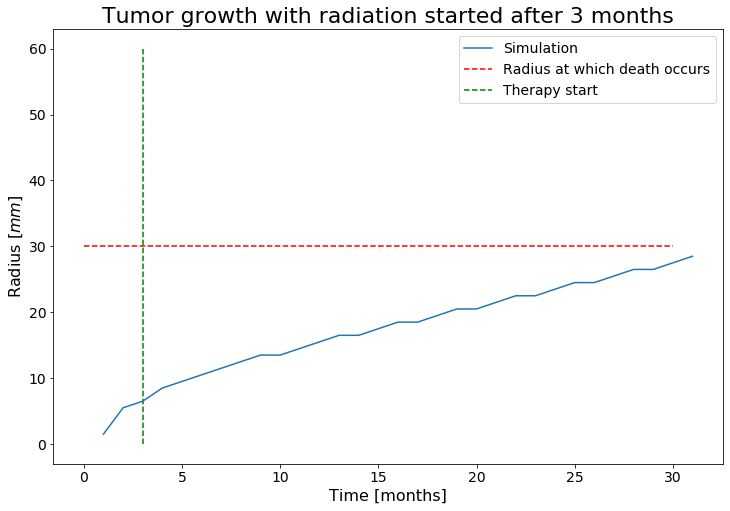

In [97]:
plt.figure(figsize=(12,8))
plt.plot(df['time'].to_list(), df['radius'].to_list(), label='Simulation')
# plt.plot(t, theoretical, label=r'Theoretical: $2t\sqrt{D\rho}\sqrt{1-\frac{1}{\rho t}\log\left(\frac{c_1}{N} (4\pi Dt)^{1.5}\right)}$')
# plt.scatter(time_of_death, 30, s=100, c='red', label=f'Time of death = {round(time_of_death, 2)}')
plt.hlines(30, 0, 30, colors='red', linestyles='--', label='Radius at which death occurs')
plt.vlines(THERAPY_TIME[0], 0, 60, colors='green', linestyles='--', label='Therapy start')
plt.legend(fontsize=14)
plt.title(f'Tumor growth with radiation started after {THERAPY_TIME[0]} months', fontdict={'size': 22})
plt.xlabel('Time [months]', fontdict={'size': 16})
plt.ylabel(r'Radius [$mm$]', fontdict={'size': 16})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(os.path.join('figs', 'pngs', 'radiation_growth.png'))
plt.show()

In [98]:
!convert -delay 25 -loop 0 `ls -v figs/pngs/radiation/*.png` figs/gifs/radiation.gif

In [99]:
Image(url=os.path.join('figs', 'gifs', 'radiation.gif'))  